In [ ]:
#Library import
from google.colab import files
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [ ]:
# Trigger the upload prompt
uploaded = files.upload()

#Get the filename (it's stored as a key in the dictionary)
file_name = list(uploaded.keys())[0]



Saving t_s1_am_6am.csv to t_s1_am_6am (1).csv


In [ ]:
# Read the CSV into a Pandas DataFrame
soil_df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Show the first few rows
soil_df.head()

,VV,VH,smap_am,soil_moisture
0,-9.058618,-15.982408,0.284554,0.301
1,-9.511266,-18.085192,0.218601,0.172
2,-10.926619,-19.470199,0.286454,0.485
3,-8.650778,-14.840568,0.407210,0.143
4,-6.633557,-13.470629,0.420252,0.375




---



#EDA and preprocessing using Pandas Profiling

In [ ]:
!pip install ydata-profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
from ydata_profiling import ProfileReport

# Generate the report
profile = ProfileReport(soil_df, title="Soil Data Analysis Report", explorative=True)

# View it directly in your Colab/Jupyter cell
profile.to_notebook_iframe()

# Or save it as an HTML file to share with your boss
profile.to_file("eda_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 17.42it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#EDA and preprocessing step by step(without pandas profiling)




---



In [ ]:
soil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30747 entries, 0 to 30746
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   VV             30747 non-null  float64
 1   VH             30747 non-null  float64
 2   smap_am        30747 non-null  float64
 3   soil_moisture  30747 non-null  float64
dtypes: float64(4)
memory usage: 961.0 KB


In [ ]:
soil_df.isnull().sum()#check null value

,0
VV,0
VH,0
smap_am,0
soil_moisture,0


In [ ]:
soil_df.duplicated().sum()# chack duplicate rows

np.int64(13)

In [ ]:
soil_df=soil_df.drop_duplicates()#drop duplicate rows

In [ ]:
soil_df.describe()#give statistical value

,VV,VH,smap_am,soil_moisture
count,30734.000000,30734.000000,30734.000000,30734.000000
mean,-9.196386,-16.418210,0.147196,0.412658
std,2.943877,3.413933,0.121549,17.750718
min,-26.670000,-35.349515,0.000000,0.000000
25%,-10.846726,-18.015636,0.070999,0.078000
50%,-9.105106,-15.784743,0.125320,0.174000
75%,-7.631884,-14.172247,0.202307,0.279000
max,5.057968,-4.289361,0.674961,1396.570000




*  vv :- typical range (-25 to 0)
*  VH :- typical range (-30 to -5)
*  smap_am :- typical range(0 to 0.6)
*  soil_moisture :- typical range(0 to 1). less than 0 and greater than than 1 is pyssically impossible. where 0 → completely dry soil.
1 → soil volume completely filled with water (theoretical saturation limit)





###Here observe that soil_moisture greater than 1 i.e. max=1396. I drop all row with soil_moisture greater than 1. Because that is not physsically possible.

In [ ]:
impossible_soil_moisture=soil_df[soil_df['soil_moisture']>1]
impossible_soil_moisture

,VV,VH,smap_am,soil_moisture
1081,-8.850859,-14.648176,0.214708,1395.560
1129,-8.606507,-14.642799,0.390132,2.332
1396,-8.306701,-14.297411,0.332181,2.413
1680,-8.085881,-14.569965,0.425239,2.358
1981,-8.396363,-15.222710,0.371598,2.199
2287,-8.670070,-14.729752,0.425239,2.249
2560,-8.477920,-14.669714,0.261589,2.292
3239,-8.667996,-15.518744,0.314346,2.264
3903,-8.678424,-15.233930,0.333234,2.231
4273,-8.480502,-14.471430,0.370183,2.193


In [ ]:

# soil_moisture quantiles (to detect outliers)
q = soil_df['soil_moisture'].quantile([0.5, 0.9, 0.95, 0.99, 0.999, 0.9999])
print("\nsoil_moisture quantiles:\n", q)

outliers = soil_df[soil_df['soil_moisture'] > 1.0]
print("\nCount(soil_moisture > 1.0):", len(outliers))
if len(outliers) > 0:
    print(outliers[['soil_moisture']].head(10))


soil_moisture quantiles:
 0.5000       0.174000
0.9000       0.359000
0.9500       0.399000
0.9900       0.495000
0.9990       0.669000
0.9999    1390.413653
Name: soil_moisture, dtype: float64

Count(soil_moisture > 1.0): 22
      soil_moisture
1081       1395.560
1129          2.332
1396          2.413
1680          2.358
1981          2.199
2287          2.249
2560          2.292
3239          2.264
3903          2.231
4273          2.193


In [ ]:
q = soil_df['VV'].quantile([0.5, 0.9, 0.95, 0.99, 0.999, 0.9999])
print("\nVV quantiles:\n", q)


VV quantiles:
 0.5000   -9.105106
0.9000   -5.740910
0.9500   -4.197929
0.9900   -1.305408
0.9990    1.562217
0.9999    3.612093
Name: VV, dtype: float64


In [ ]:
q = soil_df['VH'].quantile([0.5, 0.9, 0.95, 0.99, 0.999, 0.9999])
print("\nVH quantiles:\n", q)


VH quantiles:
 0.5000   -15.784743
0.9000   -12.912326
0.9500   -12.025535
0.9900    -9.708132
0.9990    -7.558388
0.9999    -4.734073
Name: VH, dtype: float64


In [ ]:
q = soil_df['smap_am'].quantile([0.5, 0.9, 0.95, 0.99, 0.999, 0.9999])
print("\nsmap_am quantiles:\n", q)


smap_am quantiles:
 0.5000    0.125320
0.9000    0.320945
0.9500    0.402136
0.9900    0.522607
0.9990    0.596228
0.9999    0.652176
Name: smap_am, dtype: float64


###22 rows are physsically impossible

##Histogram

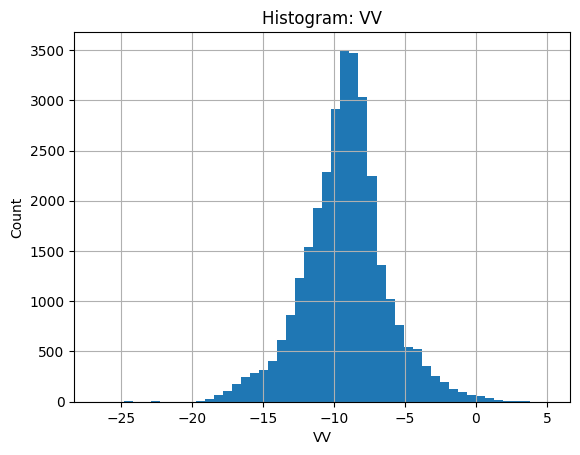

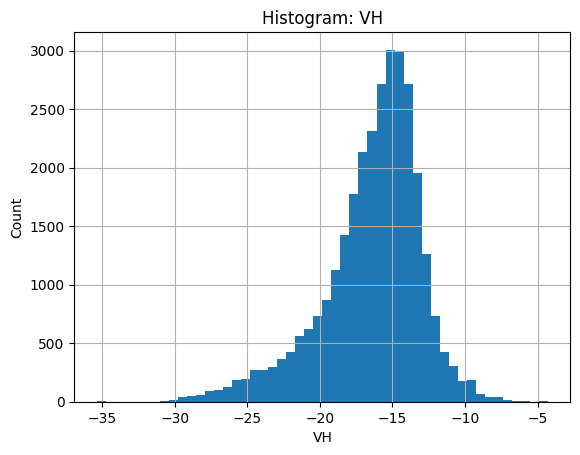

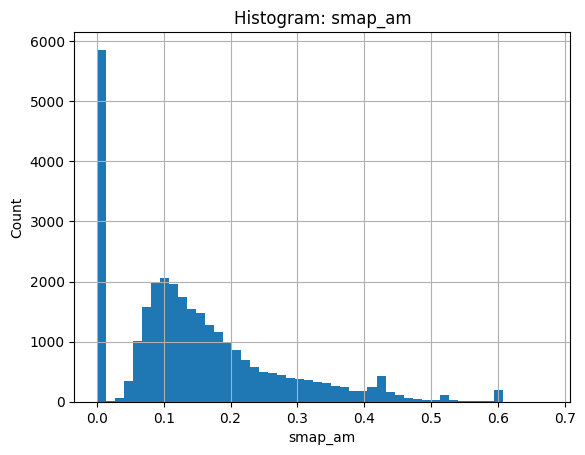

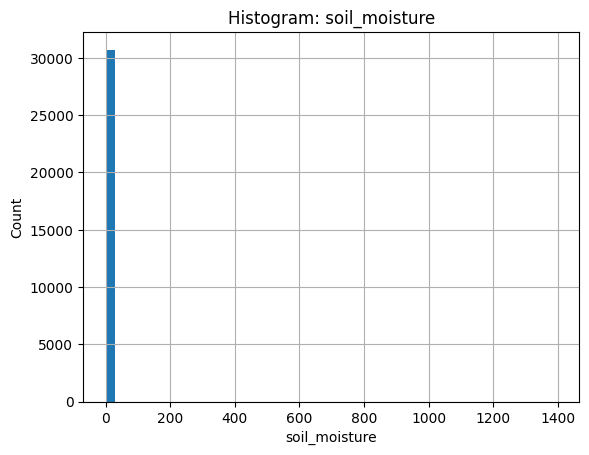

In [ ]:
import matplotlib.pyplot as plt
for col in soil_df.columns:
    plt.figure()
    soil_df[col].hist(bins=50)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


##Correlation

In [ ]:
target = "soil_moisture"
features = ["VV", "VH", "smap_am"]


Correlation matrix:
                      VV        VH   smap_am  soil_moisture
VV             1.000000  0.888137  0.146417      -0.000257
VH             0.888137  1.000000  0.282823       0.005085
smap_am        0.146417  0.282823  1.000000       0.005980
soil_moisture -0.000257  0.005085  0.005980       1.000000


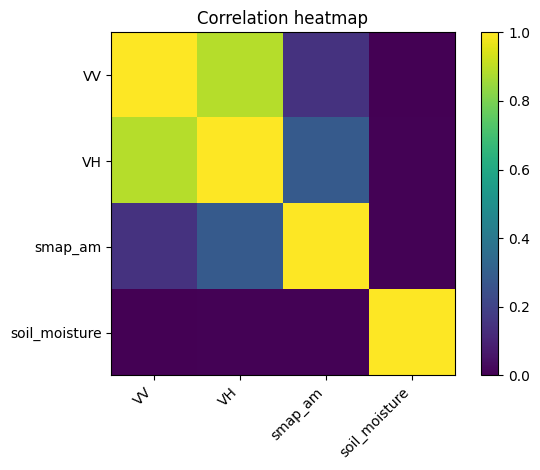

In [ ]:
# Correlation
corr = soil_df[features + [target]].corr(numeric_only=True)
print("\nCorrelation matrix:\n", corr)

plt.figure()
plt.imshow(corr.values)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.title("Correlation heatmap")
plt.tight_layout()
plt.show()

## 'VV'  and 'VH' are more correlated

In [ ]:
soil_df.corr(numeric_only=True)["soil_moisture"]


,soil_moisture
VV,-0.000257
VH,0.005085
smap_am,0.005980
soil_moisture,1.000000


#Scatter plot

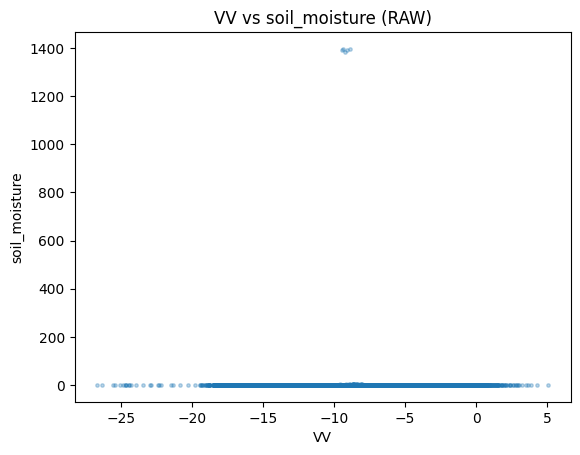

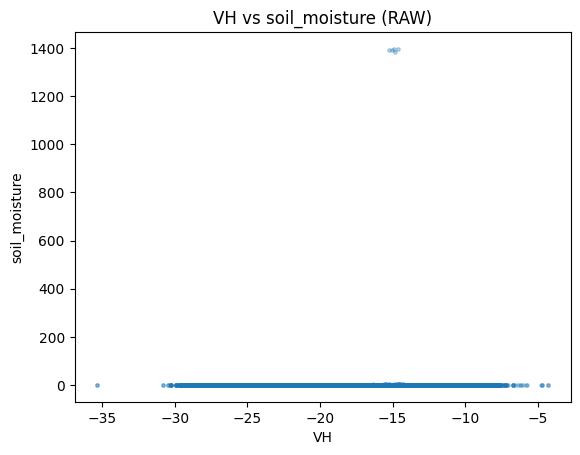

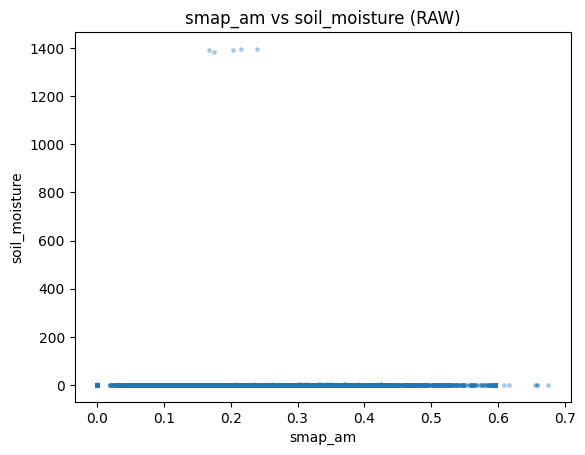

In [ ]:
for col in features:
    plt.figure()
    plt.scatter(soil_df[col], soil_df[target], s=6, alpha=0.3)
    plt.title(f"{col} vs soil_moisture (RAW)")
    plt.xlabel(col)
    plt.ylabel("soil_moisture")
    plt.show()


##Clean outliers in target


Cleaned shape: (30712, 4)


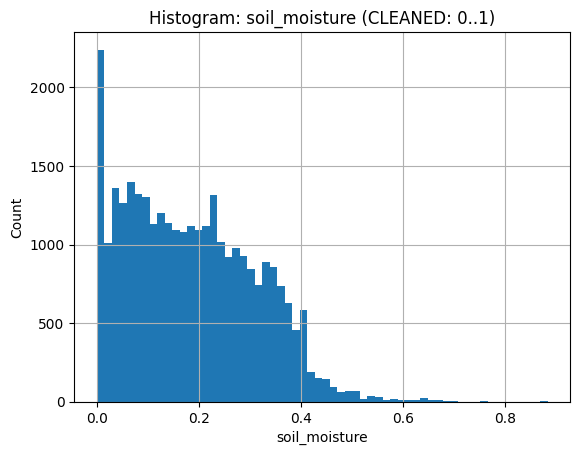

In [ ]:
# Assumption: soil_moisture should be within [0, 1]
soil_df_clean = soil_df[(soil_df[target] >= 0) & (soil_df[target] <= 1)].copy()
print("\nCleaned shape:", soil_df_clean.shape)

plt.figure()
soil_df_clean[target].hist(bins=60)
plt.title("Histogram: soil_moisture (CLEANED: 0..1)")
plt.xlabel("soil_moisture")
plt.ylabel("Count")
plt.show()

In [ ]:
soil_df_clean.describe()

,VV,VH,smap_am,soil_moisture
count,30712.000000,30712.000000,30712.000000,30712.000000
mean,-9.196714,-16.419252,0.147097,0.185072
std,2.944885,3.414908,0.121509,0.125689
min,-26.670000,-35.349515,0.000000,0.000000
25%,-10.847767,-18.019482,0.070944,0.078000
50%,-9.105670,-15.785823,0.125207,0.174000
75%,-7.631341,-14.170208,0.202172,0.279000
max,5.057968,-4.289361,0.674961,0.883000


In [ ]:
soil_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30712 entries, 0 to 30746
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   VV             30712 non-null  float64
 1   VH             30712 non-null  float64
 2   smap_am        30712 non-null  float64
 3   soil_moisture  30712 non-null  float64
dtypes: float64(4)
memory usage: 1.2 MB


In [ ]:
soil_df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
VV,30712.0,-9.196714,2.944885,-26.670000,-10.847767,-9.105670,-7.631341,5.057968
VH,30712.0,-16.419252,3.414908,-35.349515,-18.019482,-15.785823,-14.170208,-4.289361
smap_am,30712.0,0.147097,0.121509,0.000000,0.070944,0.125207,0.202172,0.674961
soil_moisture,30712.0,0.185072,0.125689,0.000000,0.078000,0.174000,0.279000,0.883000


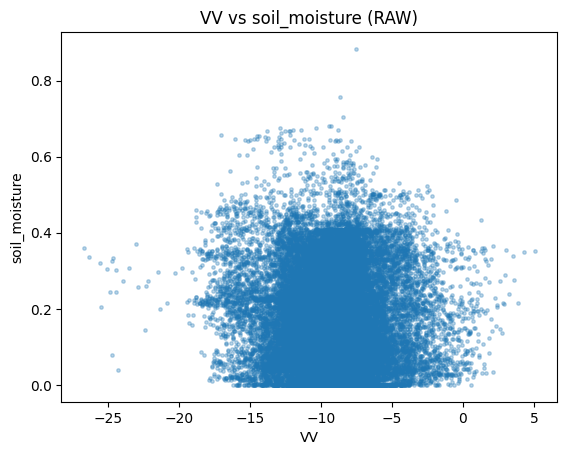

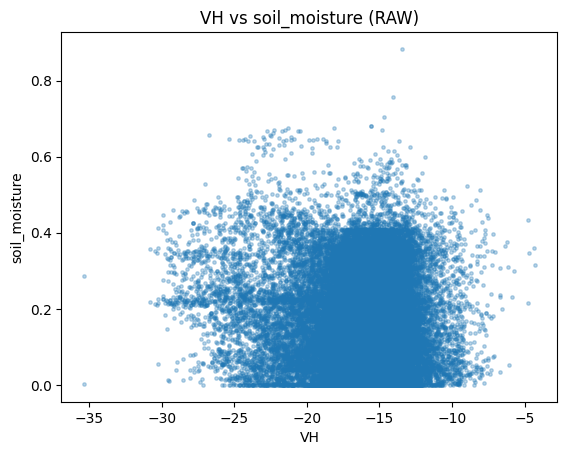

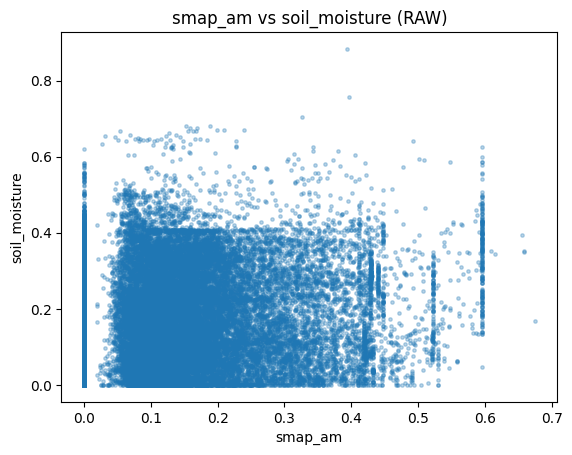

In [ ]:
#scatter plot after outlier clean
for col in features:
    plt.figure()
    plt.scatter(soil_df_clean[col], soil_df_clean[target], s=6, alpha=0.3)
    plt.title(f"{col} vs soil_moisture (RAW)")
    plt.xlabel(col)
    plt.ylabel("soil_moisture")
    plt.show()


In [ ]:
# #Yeo-Johnson Transformation
# from sklearn.preprocessing import PowerTransformer

# pt = PowerTransformer(method="yeo-johnson")
# soil_df_clean[features] = pt.fit_transform(soil_df_clean[features])


#Log transformation
import numpy as np

# Column-wise minimum
min_vals = soil_df_clean[features].min()

# Overwrite original columns
soil_df_clean[features] = np.log(
    soil_df_clean[features] - min_vals + 1
)



In [ ]:


for col in features:
    count = (soil_df_clean[col] == 0).sum()
    print(f"{col}: {count}")


VV: 1
VH: 2
smap_am: 5857


In [ ]:
soil_df_clean = soil_df_clean[soil_df_clean["smap_am"] != 0].copy()

In [ ]:


for col in features:
    count = (soil_df_clean[col] == 0).sum()
    print(f"{col}: {count}")


VV: 1
VH: 0
smap_am: 0


In [ ]:
soil_df_clean[features].skew()


,0
VV,-1.697095
VH,-1.818655
smap_am,1.151667


In [ ]:
soil_df_clean["soil_moisture"].skew()

np.float64(0.4748824338791512)

In [ ]:
soil_df_clean['smap_am'] = np.sqrt(soil_df_clean['smap_am'])

In [ ]:

from scipy.stats import boxcox

soil_df_clean['smap_am'], _ = boxcox(soil_df_clean['smap_am'])


In [ ]:
soil_df_clean[features].skew()


,0
VV,-1.697095
VH,-1.818655
smap_am,0.005185


In [ ]:
#feature engineering
# soil_df_clean["VV-VH"] = soil_df_clean["VV"] - soil_df_clean["VH"]
soil_df_clean["VVDivVH"]= soil_df_clean["VV"] / soil_df_clean["VH"]
# soil_df_clean["VVMulVH"]= soil_df_clean["VV"] * soil_df_clean["VH"]
soil_df_clean

,VV,VH,smap_am,soil_moisture,VVDivVH
0,2.923773,3.013921,-0.724075,0.301,0.970089
1,2.899152,2.904950,-0.854232,0.172,0.998004
2,2.818003,2.826089,-0.720859,0.485,0.997139
3,2.945450,3.068469,-0.556021,0.143,0.959909
4,3.046256,3.130214,-0.541756,0.375,0.973178
...,...,...,...,...,...
30742,2.953369,3.071472,-0.873903,0.123,0.961549
30743,3.056374,3.170355,-0.645610,0.066,0.964048
30744,2.995984,3.078796,-0.838532,0.131,0.973102
30745,2.831349,2.958497,-1.333755,0.177,0.957023


In [ ]:
soil_df_clean.describe()

,VV,VH,smap_am,soil_moisture,VVDivVH
count,24855.000000,24855.000000,24855.000000,24855.000000,24855.000000
mean,2.898777,2.977340,-1.042524,0.183963,0.974933
std,0.174253,0.206992,0.293152,0.127220,0.035928
min,0.000000,1.716374,-2.230344,0.000000,0.000000
25%,2.819402,2.909425,-1.255154,0.075000,0.955344
50%,2.924468,3.036378,-1.050304,0.171000,0.966538
75%,2.998506,3.106054,-0.834859,0.278000,0.985525
max,3.410187,3.467614,-0.338174,0.883000,1.380987


In [ ]:
features = ["VV", "VH", "smap_am","VVDivVH"]
target = "soil_moisture"

In [ ]:
features

['VV', 'VH', 'smap_am', 'VVDivVH']

In [ ]:
# # #Yeo-Johnson Transformation
# # from sklearn.preprocessing import PowerTransformer

# # pt = PowerTransformer(method="yeo-johnson")
# # soil_df_clean[features] = pt.fit_transform(soil_df_clean[features])


# #Log transformation
# import numpy as np

# # Column-wise minimum
# min_vals = soil_df_clean[features].min()

# # Overwrite original columns
# soil_df_clean[features] = np.log(
#     soil_df_clean[features] - min_vals + 1
# )



In [ ]:


for col in features:
    count = (soil_df_clean[col] == 0).sum()
    print(f"{col}: {count}")


VV: 1
VH: 0
smap_am: 0
VVDivVH: 1


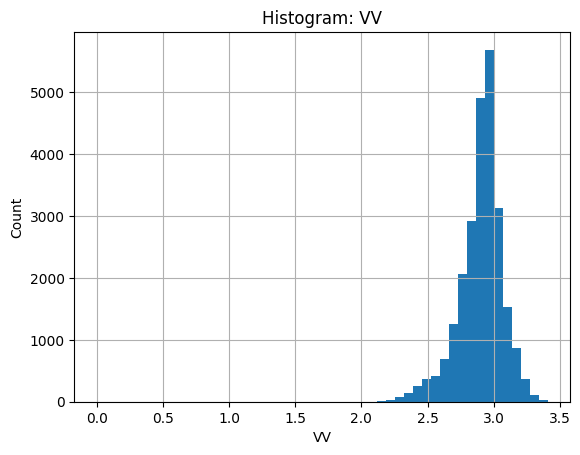

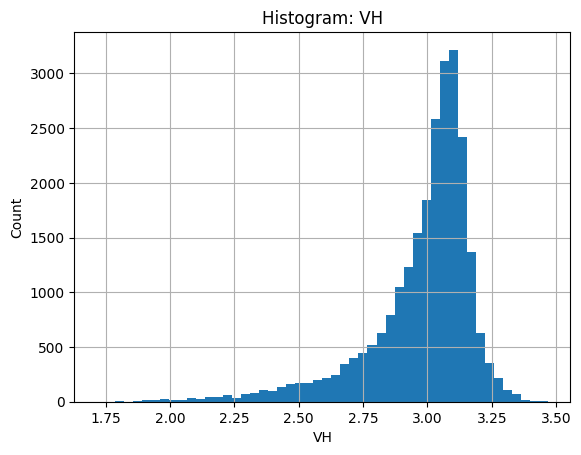

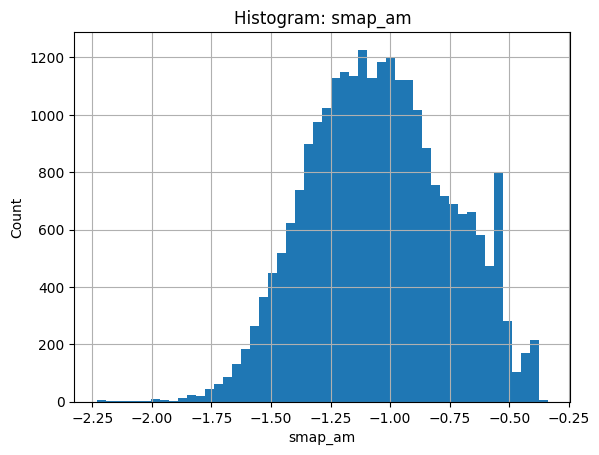

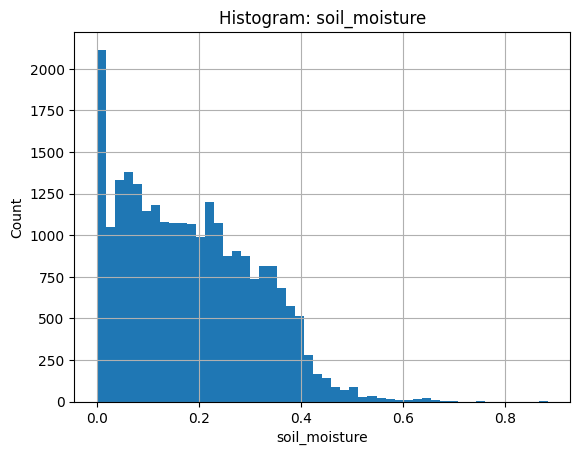

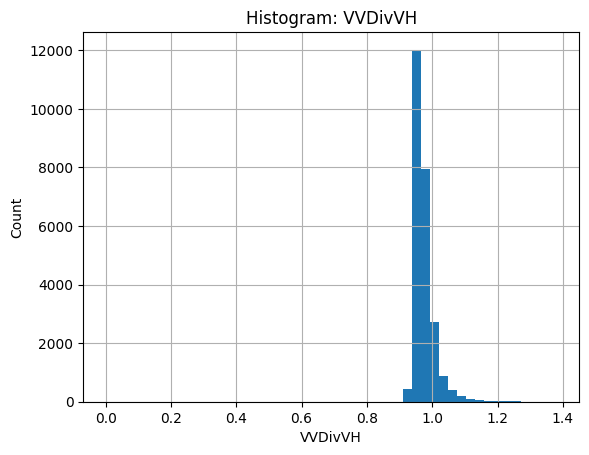

In [ ]:
import matplotlib.pyplot as plt
for col in soil_df_clean.columns:
    plt.figure()
    soil_df_clean[col].hist(bins=50)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


In [ ]:
soil_df_clean.shape

(24855, 5)

In [ ]:
for col in features:
    unique_count = soil_df_clean[col].nunique()
    print(f"{col}: {unique_count}")


VV: 23113
VH: 23114
smap_am: 23239
VVDivVH: 23430


In [ ]:
soil_df_clean[features].skew()


,0
VV,-1.697095
VH,-1.818655
smap_am,0.005185
VVDivVH,0.001761


In [ ]:
zero_cnt_soil_moisture=(soil_df_clean['soil_moisture']==0).sum()
zero_cnt_soil_moisture

np.int64(1007)

In [ ]:
soil_df_clean

,VV,VH,smap_am,soil_moisture,VVDivVH
0,2.923773,3.013921,-0.724075,0.301,0.970089
1,2.899152,2.904950,-0.854232,0.172,0.998004
2,2.818003,2.826089,-0.720859,0.485,0.997139
3,2.945450,3.068469,-0.556021,0.143,0.959909
4,3.046256,3.130214,-0.541756,0.375,0.973178
...,...,...,...,...,...
30742,2.953369,3.071472,-0.873903,0.123,0.961549
30743,3.056374,3.170355,-0.645610,0.066,0.964048
30744,2.995984,3.078796,-0.838532,0.131,0.973102
30745,2.831349,2.958497,-1.333755,0.177,0.957023


###split into train and test samples

In [ ]:
X = soil_df_clean[features]
y = soil_df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X_train.shape

(19884, 4)

In [ ]:
X_test.shape

(4971, 4)

In [ ]:
y_train.shape

(19884,)

In [ ]:
y_test.shape

(4971,)

In [ ]:
 # Metric helper

def evaluate(model, X_train, y_train, X_test, y_test, name="model"):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    print(f"\n[{name}]")
    print("  RMSE:", rmse)
    print("  MAE :", mae)
    print("  R^2 :", r2)
    return {"name": name, "rmse": rmse, "mae": mae, "r2": r2, "model": model}

###Train multiple models (ML + DL-style MLP)

In [ ]:

models = []

# Baseline: predict mean
models.append(("DummyMean", DummyRegressor(strategy="mean")))

# Linear
models.append(("LinearRegression", Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])))

models.append(("Ridge", Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])))

# Tree ensembles (no scaling needed)
models.append(("RandomForest", RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)))

models.append(("HistGB", HistGradientBoostingRegressor(
    random_state=42,
    max_depth=6,
    learning_rate=0.05,
    max_iter=500
)))


# “DL” style: MLPRegressor (needs scaling)
models.append(("MLPRegressor", Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 64),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=500,
        random_state=42
    ))
])))


In [ ]:
results = []
for name, model in models:
    results.append(evaluate(model, X_train, y_train, X_test, y_test, name=name))

res_df = pd.DataFrame([{k: v for k, v in r.items() if k != "model"} for r in results])
print("\nSummary (sorted by RMSE):")
print(res_df.sort_values("rmse"))




[DummyMean]
  RMSE: 0.12588547865250765
  MAE : 0.10649808610318039
  R^2 : -0.00045345014667086403

[LinearRegression]
  RMSE: 0.124578809717651
  MAE : 0.1052150102641098
  R^2 : 0.020207818922076903

[Ridge]
  RMSE: 0.12457924645229444
  MAE : 0.10521515080740525
  R^2 : 0.020200949215424924

[RandomForest]
  RMSE: 0.12233752186993099
  MAE : 0.1006450572757307
  R^2 : 0.055145418868101315

[HistGB]
  RMSE: 0.11986254249936823
  MAE : 0.10015947821373171
  R^2 : 0.09298893254252405

[MLPRegressor]
  RMSE: 0.12142222036557863
  MAE : 0.10239113531504024
  R^2 : 0.06923090282406019

Summary (sorted by RMSE):
               name      rmse       mae        r2
4            HistGB  0.119863  0.100159  0.092989
5      MLPRegressor  0.121422  0.102391  0.069231
3      RandomForest  0.122338  0.100645  0.055145
1  LinearRegression  0.124579  0.105215  0.020208
2             Ridge  0.124579  0.105215  0.020201
0         DummyMean  0.125885  0.106498 -0.000453
